# Exploratory Data Analysis on Intel Image Classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [12]:
# 1. Set the path to your training data
base_dir = "archive/seg_train/seg_train"

# 2. List the classes (folders) to confirm
classes = sorted(os.listdir(base_dir))
print("Classes found:", classes)

# 3. Count images per class
class_counts = {cls: len(os.listdir(os.path.join(base_dir, cls))) 
                for cls in classes}
print("Image counts per class:")
for cls, cnt in class_counts.items():
    print(f"  {cls}: {cnt}")

Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Image counts per class:
  buildings: 2191
  forest: 2271
  glacier: 2404
  mountain: 2512
  sea: 2274
  street: 2382


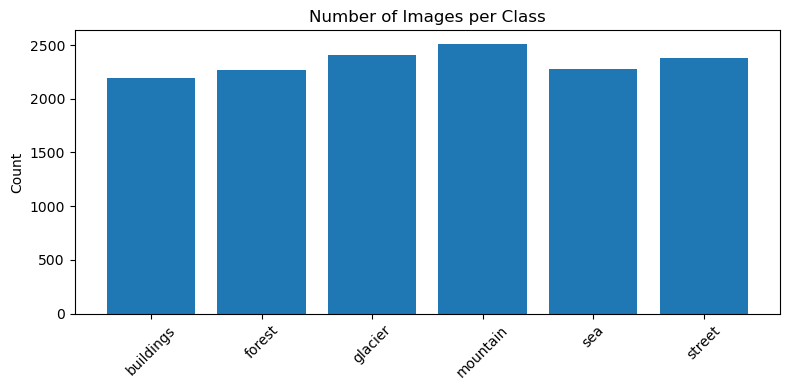

In [13]:
# Visualize the class distribution

plt.figure(figsize=(8,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Number of Images per Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

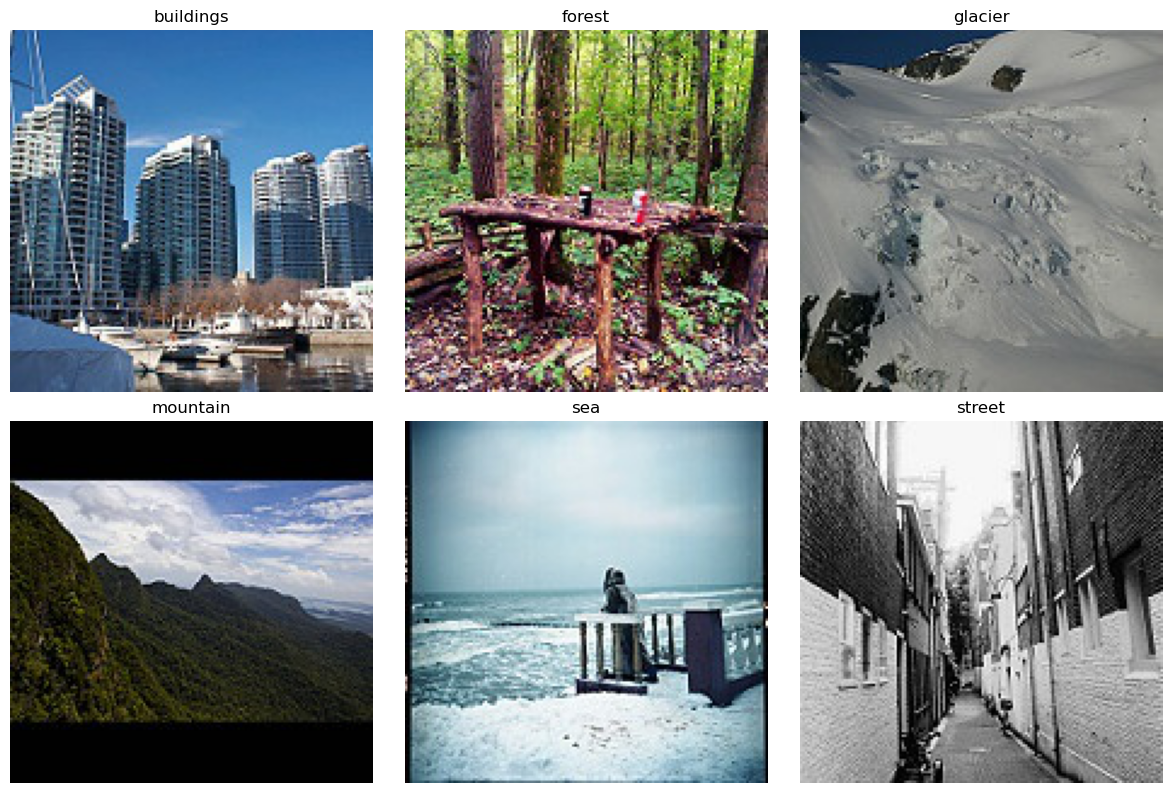

In [14]:
# Display a few sample images per class
import random

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    # pick a random image file
    fname = random.choice(os.listdir(os.path.join(base_dir, cls)))
    img = Image.open(os.path.join(base_dir, cls, fname))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
# Create flattened arrays (We will be using this for MLP and Logistic Regression models):
# Remember, we do not have all of the same sized images (150 x 150). So we will have to resize all of the images to 150 x 150  pixels. 

# Find out which of the images do not have consistent sizes:

from collections import Counter
shape_counts = Counter()

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    for fname in os.listdir(cls_path):
        img = Image.open(os.path.join(cls_path, fname)).convert("RGB")
        shape_counts[img.size + (len(img.getbands()),)] += 1  # (width, height, channels)

print("Image shapes and their counts:")
for shape, cnt in shape_counts.items():
    print(f"  {shape}: {cnt}")

Image shapes and their counts:
  (150, 150, 3): 13986
  (150, 124, 3): 1
  (150, 115, 3): 1
  (150, 108, 3): 2
  (150, 136, 3): 2
  (150, 135, 3): 3
  (150, 133, 3): 1
  (150, 113, 3): 7
  (150, 111, 3): 3
  (150, 134, 3): 2
  (150, 142, 3): 2
  (150, 149, 3): 1
  (150, 76, 3): 1
  (150, 123, 3): 2
  (150, 105, 3): 1
  (150, 102, 3): 1
  (150, 143, 3): 2
  (150, 146, 3): 2
  (150, 120, 3): 1
  (150, 110, 3): 1
  (150, 97, 3): 1
  (150, 119, 3): 1
  (150, 147, 3): 1
  (150, 103, 3): 1
  (150, 131, 3): 1
  (150, 144, 3): 2
  (150, 100, 3): 1
  (150, 81, 3): 1
  (150, 141, 3): 1
  (150, 145, 3): 1
  (150, 140, 3): 1


In [22]:
# As we can see above, we have some images not of size 150x150. 
# We resize the above outlier images to 150x150, so that we can compress it to RGB 1D arrays.

import os
from PIL import Image

target_size = (150, 150)

for root, dirs, files in os.walk(base_dir):
    for fname in files:
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(root, fname)
        img = Image.open(img_path).convert('RGB')
        if img.size != target_size:
            # Use LANCZOS resampling instead of ANTIALIAS
            img = img.resize(target_size, resample=Image.LANCZOS)
            img.save(img_path)

print("All images resized to 150×150.")

All images resized to 150×150.


In [25]:
## Lets check if all the images are of the same size:

shape_counts = Counter()

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    for fname in os.listdir(cls_path):
        img = Image.open(os.path.join(cls_path, fname)).convert("RGB")
        shape_counts[img.size + (len(img.getbands()),)] += 1  # (width, height, channels)

print("Image shapes and their counts:")
for shape, cnt in shape_counts.items():
    print(f"  {shape}: {cnt}")

Image shapes and their counts:
  (150, 150, 3): 14034


- **`X`** is your **feature matrix**. It’s a NumPy array of shape `(N, 67500)`, where:
  - **`N`** is the total number of images you loaded.  
  - **`67500`** comes from flattening each `150×150×3` RGB image into a one-dimensional vector (`150 × 150 × 3 = 67500`).  
  - **Each row** of `X` corresponds to one image and contains its pixel values in the order:  
    ```
    [R₁, G₁, B₁, R₂, G₂, B₂, …, Rₙ, Gₙ, Bₙ]
    ```  
    where each triplet is the red, green, blue channels of a single pixel.

- **`y`** is your **label vector**. It’s a NumPy array of shape `(N,)`, where each entry is an integer in `[0…5]` indicating which class that image belongs to:
  - For example, if  
    ```python
    classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    ```  
    then a `y` value of `2` means “glacier.”

---

So in effect, you have one flattened feature vector per image in `X`, and the matching class index in `y`. Together, `(X[i], y[i])` is the feature–label pair you’ll feed into your Logistic Regression or MLP models.  

In [26]:
# 3. Initialize lists for feature vectors and labels
X = []
y = []

# 4. Loop through each class folder and each image file
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    for fname in os.listdir(cls_path):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(cls_path, fname)
        img = Image.open(img_path).convert("RGB")
        # Convert to numpy array and flatten to 1D vector
        arr = np.array(img)               # shape: (150, 150, 3)
        X.append(arr.flatten())           # shape: (67500,)
        y.append(classes.index(cls))

# 5. Convert lists to numpy arrays
X = np.stack(X)  # shape: (N_samples, 67500)
y = np.array(y)  # shape: (N_samples,)

# 6. Display shapes
print(f"Feature matrix X shape: {X.shape}")
print(f"Label vector y shape: {y.shape}")

Feature matrix X shape: (14034, 67500)
Label vector y shape: (14034,)


### Now that we have our flattened feature matrix `X`, and label vector `y`, here are some key EDA steps to understand how the RGB channels vary by class

#### Compute per class channel means and standard deviations:

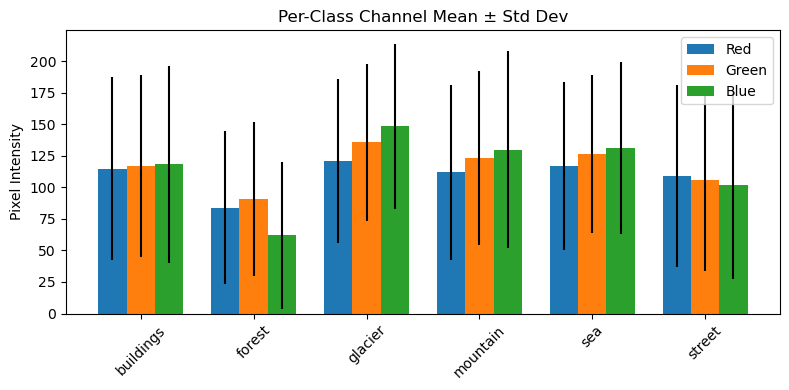

In [27]:
# Precompute channel slices
R = X[:, 0::3]
G = X[:, 1::3]
B = X[:, 2::3]

means = {'R': [], 'G': [], 'B': []}
stds  = {'R': [], 'G': [], 'B': []}

for i, cls in enumerate(classes):
    idx = np.where(y == i)
    means['R'].append(R[idx].mean())
    means['G'].append(G[idx].mean())
    means['B'].append(B[idx].mean())
    stds ['R'].append(R[idx].std())
    stds ['G'].append(G[idx].std())
    stds ['B'].append(B[idx].std())

# Plotting
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width, means['R'], width, yerr=stds['R'], label='Red')
ax.bar(x        , means['G'], width, yerr=stds['G'], label='Green')
ax.bar(x + width, means['B'], width, yerr=stds['B'], label='Blue')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.set_ylabel("Pixel Intensity")
ax.set_title("Per-Class Channel Mean ± Std Dev")
ax.legend()
plt.tight_layout()
plt.show()

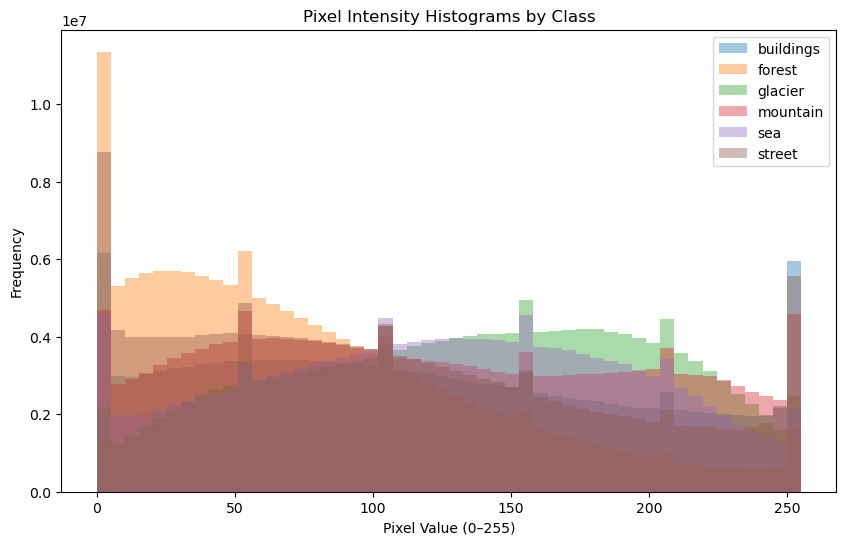

In [28]:
plt.figure(figsize=(10,6))
for i, cls in enumerate(classes):
    pixels = np.hstack([R[y==i], G[y==i], B[y==i]]).ravel()
    plt.hist(pixels, bins=50, alpha=0.4, label=cls)
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Histograms by Class")
plt.legend()
plt.show()

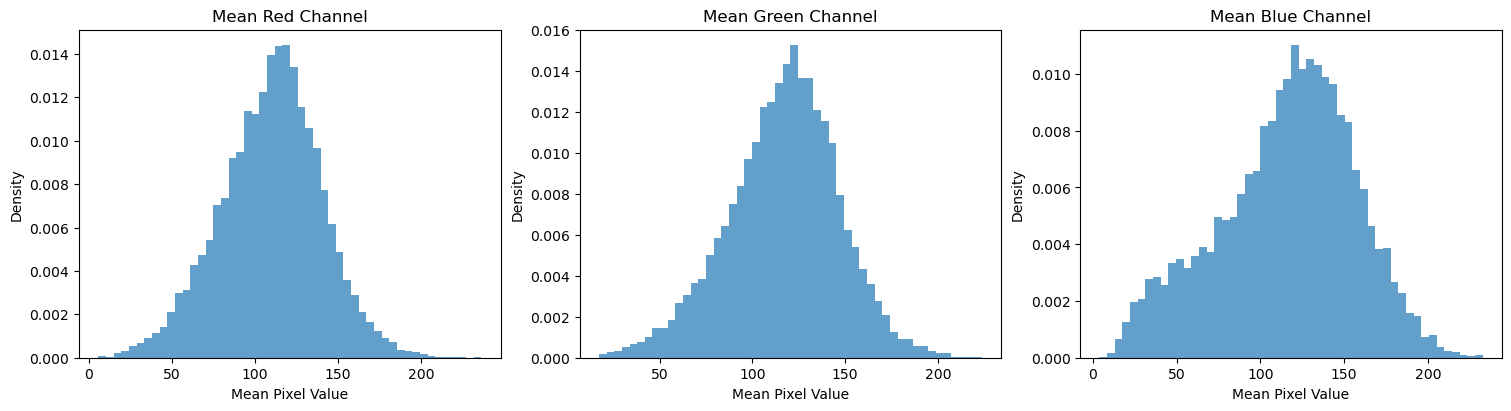

/Users/saiganesh/miniconda3/envs/cenv4py310/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


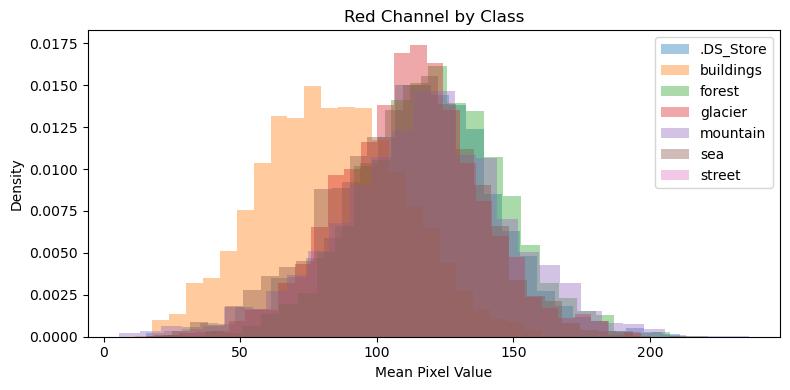

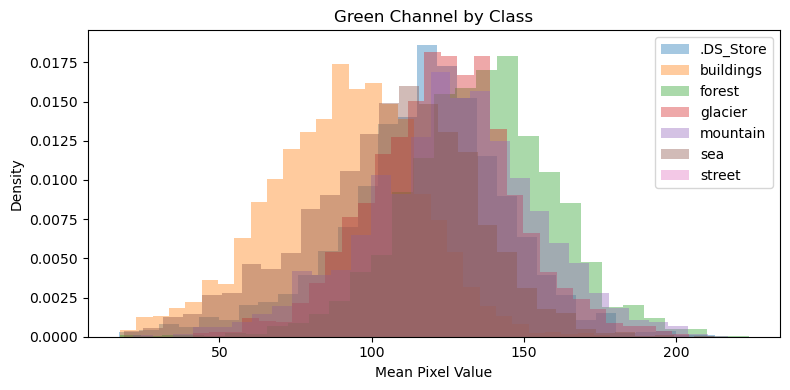

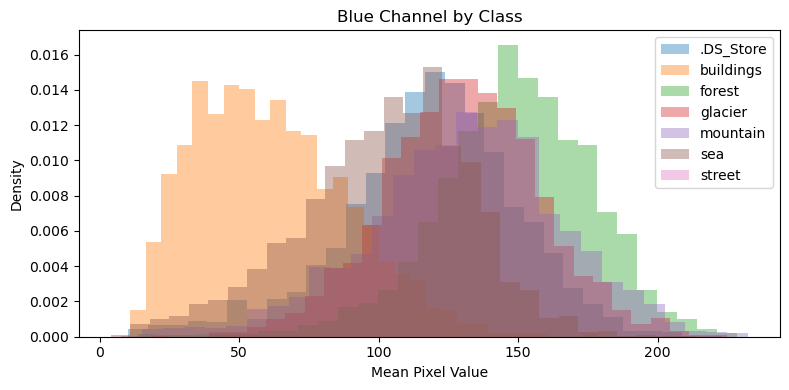

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Reshape X back into image form ---
# X.shape == (N_samples, 67500)
N = X.shape[0]
images = X.reshape(N, 150, 150, 3)  # (N, height, width, channels)

# --- 2) Compute per-image mean for each channel ---
mean_R = images[:, :, :, 0].mean(axis=(1, 2))  # shape: (N,)
mean_G = images[:, :, :, 1].mean(axis=(1, 2))
mean_B = images[:, :, :, 2].mean(axis=(1, 2))

# --- 3) Plot overall channel distributions ---
fig, ax = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
for subplot, data, color in zip(
    ax, [mean_R, mean_G, mean_B], ['Red','Green','Blue']
):
    subplot.hist(data, bins=50, density=True, alpha=0.7)
    subplot.set_title(f"Mean {color} Channel")
    subplot.set_xlabel("Mean Pixel Value")
    subplot.set_ylabel("Density")
plt.show()

# --- 4) (Optional) Per-class overlay histograms ---
for channel_data, channel_name in [(mean_R, 'Red'), (mean_G, 'Green'), (mean_B, 'Blue')]:
    plt.figure(figsize=(8,4))
    for idx, cls in enumerate(classes):
        # select all images of class idx
        vals = channel_data[y == idx]
        plt.hist(vals, bins=30, density=True, alpha=0.4, label=cls)
    plt.title(f"{channel_name} Channel by Class")
    plt.xlabel("Mean Pixel Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()